# Préparation des données

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score

# Chargement des données
customers = pd.read_excel('../../customers_data_extended.xlsx')
sales = pd.read_excel('../../sales_data_extended.xlsx')

# Nettoyage des données de ventes (certains prix sont manquants)
sales = sales.dropna(subset=['Sale_Price'])

# Calcul du total dépensé par client à partir des données de vente
customer_spending = sales.groupby('Customer_ID').agg(
    total_spent=('Sale_Price', 'sum'),
    purchase_count=('Sale_ID', 'count'),
    avg_purchase_value=('Sale_Price', 'mean')
).reset_index()

# Jointure avec les données clients
df = pd.merge(customers, customer_spending, on='Customer_ID', how='left')

# Remplissage des valeurs manquantes pour les clients sans achats
df['total_spent'] = df['total_spent'].fillna(0)
df['purchase_count'] = df['purchase_count'].fillna(0)
df['avg_purchase_value'] = df['avg_purchase_value'].fillna(0)

# Conversion des variables catégorielles
df = pd.get_dummies(df, columns=['Gender', 'Location', 'Preferred_Channel'], drop_first=True)

# Sélection des features pour le clustering
features = ['Age', 'Income', 'Email_Open_Rate', 'total_spent', 'purchase_count', 'avg_purchase_value',
            'Gender_Male', 'Preferred_Channel_Online']
X = df[features]
print(X)

# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


    Age  Income  Email_Open_Rate  total_spent  purchase_count  \
0    28   81254             0.48        150.0             1.0   
1    35  100000             0.89         25.0             1.0   
2    22   64520             0.24        150.0             1.0   
3    30   95000             0.62        442.5             4.0   
4    27   85604             0.50        386.5             4.0   
5    46   52662             0.43          0.0             0.0   
6    32   38392             0.70         60.0             1.0   
7    60   60535             0.69         75.0             1.0   
8    25  108603             0.35         90.0             1.0   
9    38   82256             0.71        300.0             3.0   
10   56  119135             0.66         75.0             1.0   
11   36   65222             0.84          0.0             0.0   
12   40  107373             0.86        309.0             3.0   
13   28  109575             0.32         25.0             1.0   
14   28  114651          

## K-mean Clustering

#### Methode de coude pour déterminer le nombre optimal de clusters et applications de k-mean

d:\Programmes\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Programmes\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Programmes\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Programmes\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with M

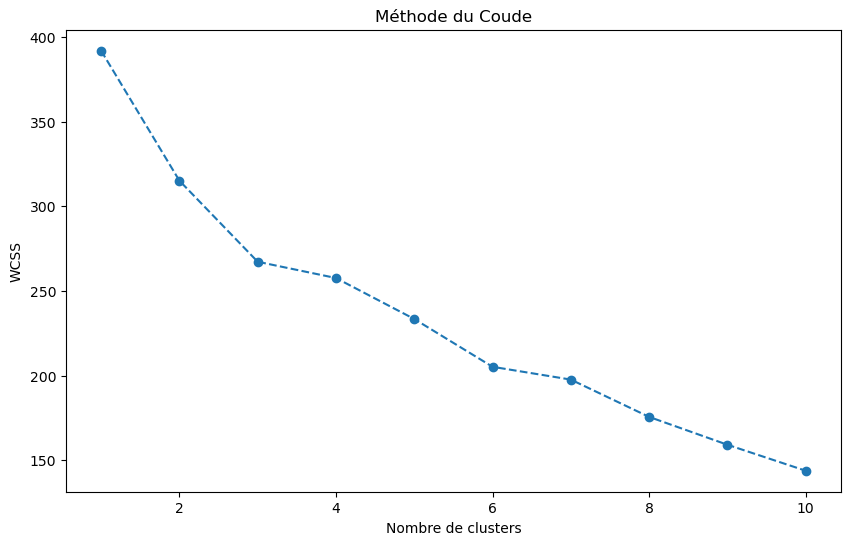

In [32]:
# Méthode du coude pour déterminer le nombre optimal de clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Méthode du Coude')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS')
plt.savefig("nombre_optimal_methode_coude.png")
plt.show()

In [26]:
# Selon le graphique , le nombre optimal est 3 
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Ajout des clusters au dataframe
df['Cluster'] = clusters

# Analyse des clusters
cluster_stats = df.groupby('Cluster')[features].mean()
print(cluster_stats)

# Score de silhouette
silhouette_avg = silhouette_score(X_scaled, clusters)
print(f"Score de silhouette moyen: {silhouette_avg:.3f}")

               Age        Income  Email_Open_Rate  total_spent  \
Cluster                                                          
0        47.000000  89708.611111         0.748333    66.333333   
1        38.090909  84902.545455         0.760909   530.590909   
2        33.600000  72593.750000         0.581000   138.950000   

         purchase_count  avg_purchase_value  Gender_Male  \
Cluster                                                    
0              1.055556           50.666667     0.555556   
1              3.545455          162.563636     0.363636   
2              1.300000          103.787500     0.500000   

         Preferred_Channel_Online  
Cluster                            
0                        0.944444  
1                        0.636364  
2                        0.200000  
Score de silhouette moyen: 0.156


d:\Programmes\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


## PCA (Analyses en Composants Principales)

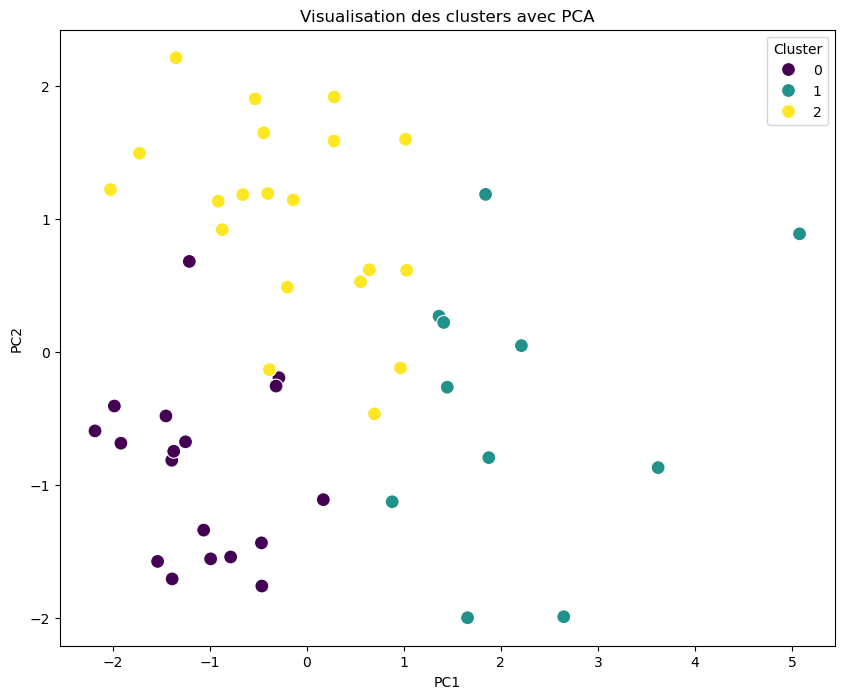

Variance expliquée par chaque composante: [0.28626874 0.16922317]


In [ ]:
# Application de PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

# Création d'un dataframe avec les composantes principales
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clusters

# Visualisation
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', s=100)
plt.title('Visualisation des clusters avec PCA')
plt.savefig("pca_clusters.png")
plt.show()

# Variance expliquée
print(f"Variance expliquée par chaque composante: {pca.explained_variance_ratio_}")

## Application de t-SNE

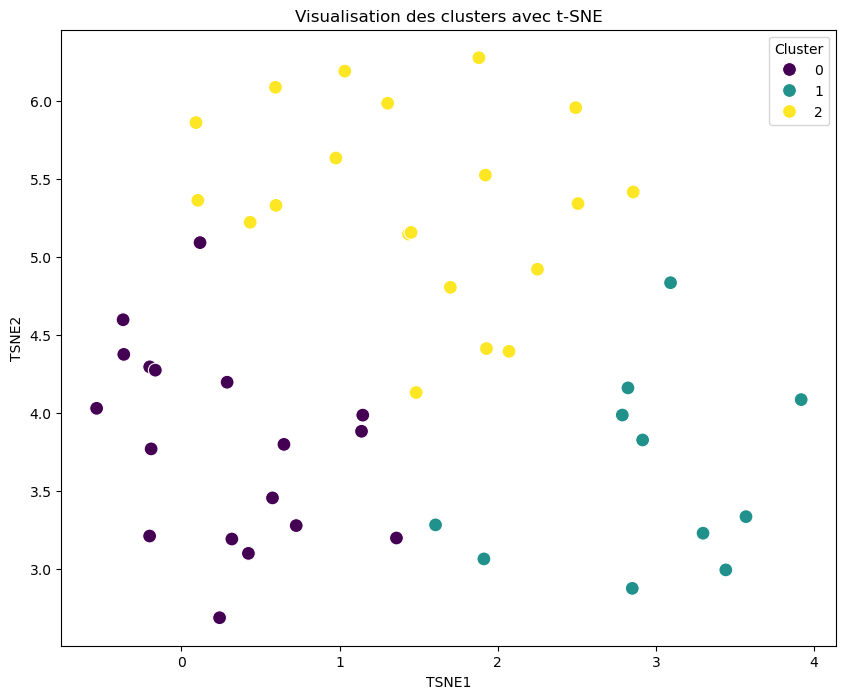

In [ ]:
# Application de t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(X_scaled)

# Création d'un dataframe avec les résultats t-SNE
tsne_df = pd.DataFrame(data=tsne_results, columns=['TSNE1', 'TSNE2'])
tsne_df['Cluster'] = clusters

# Visualisation
plt.figure(figsize=(10, 8))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='Cluster', data=tsne_df, palette='viridis', s=100)
plt.title('Visualisation des clusters avec t-SNE')
plt.savefig("t-SNE_clusters.png")
plt.show()

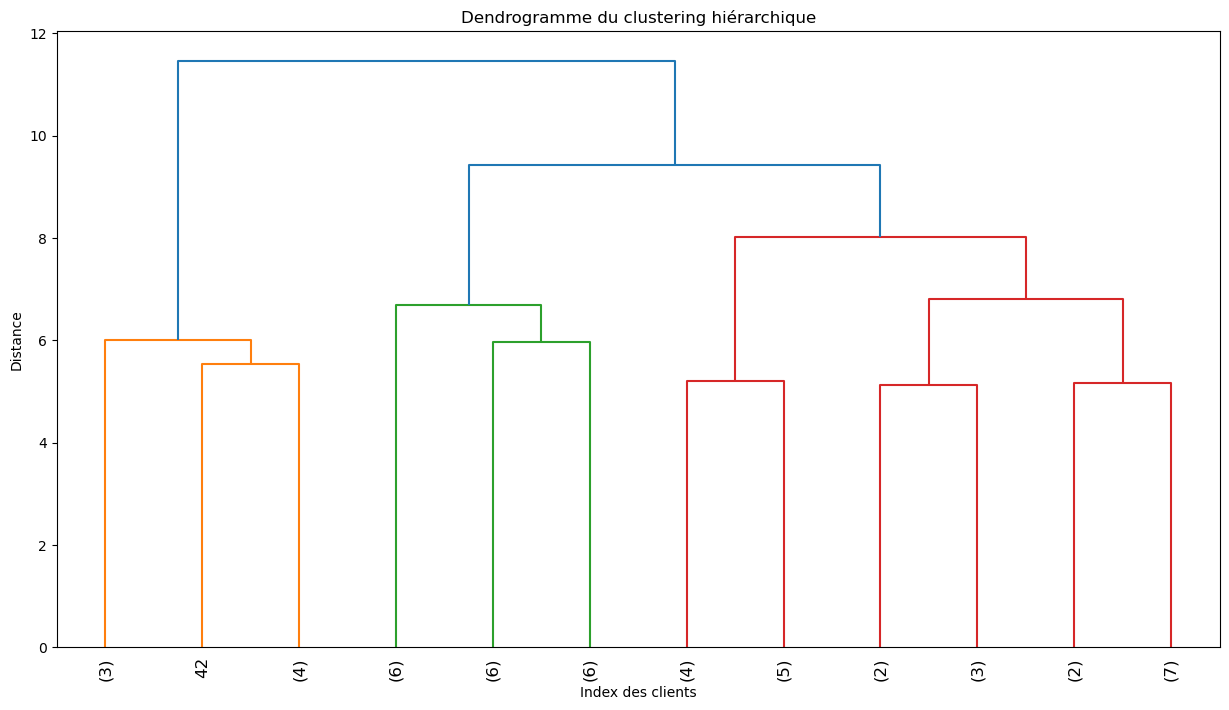

                            Age        Income  Email_Open_Rate  total_spent  \
Hierarchical_Cluster                                                          
1                     35.000000  79536.125000         0.695000   561.562500   
2                     40.414634  82055.341463         0.680488   129.682927   

                      purchase_count  avg_purchase_value  Gender_Male  \
Hierarchical_Cluster                                                    
1                           4.000000          145.962500     0.125000   
2                           1.268293           88.006098     0.560976   

                      Preferred_Channel_Online  
Hierarchical_Cluster                            
1                                     0.500000  
2                                     0.585366  


In [29]:
# Calcul de la matrice de liaison
Z = linkage(X_scaled, method='ward')

# Dendrogramme
plt.figure(figsize=(15, 8))
dendrogram(Z, truncate_mode='lastp', p=12, show_leaf_counts=True, leaf_rotation=90, leaf_font_size=12)
plt.title('Dendrogramme du clustering hiérarchique')
plt.xlabel('Index des clients')
plt.ylabel('Distance')
plt.show()

# Découpage en clusters (par exemple à distance 10)
from scipy.cluster.hierarchy import fcluster
hierarchical_clusters = fcluster(Z, t=10, criterion='distance')
df['Hierarchical_Cluster'] = hierarchical_clusters

# Analyse des clusters hiérarchiques
hierarchical_stats = df.groupby('Hierarchical_Cluster')[features].mean()
print(hierarchical_stats)

## Interprétation des Résultats

In [30]:
# Statistiques descriptives par cluster
for cluster in sorted(df['Cluster'].unique()):
    print(f"\nCluster {cluster} - Caractéristiques moyennes:")
    print(df[df['Cluster'] == cluster][features].mean())
    
    print("\nExemples de clients dans ce cluster:")
    print(df[df['Cluster'] == cluster][['Customer_ID', 'Name', 'Age', 'Income', 'total_spent']].head(3))


Cluster 0 - Caractéristiques moyennes:
Age                            47.000000
Income                      89708.611111
Email_Open_Rate                 0.748333
total_spent                    66.333333
purchase_count                  1.055556
avg_purchase_value             50.666667
Gender_Male                     0.555556
Preferred_Channel_Online        0.944444
dtype: float64

Exemples de clients dans ce cluster:
    Customer_ID             Name  Age  Income  total_spent
1          2002  Katherine Smith   35  100000         25.0
7          2008    Diane Morales   60   60535         75.0
10         2011      David Payne   56  119135         75.0

Cluster 1 - Caractéristiques moyennes:
Age                            38.090909
Income                      84902.545455
Email_Open_Rate                 0.760909
total_spent                   530.590909
purchase_count                  3.545455
avg_purchase_value            162.563636
Gender_Male                     0.363636
Preferred_Channe

## Visualisation des profils de Clusters

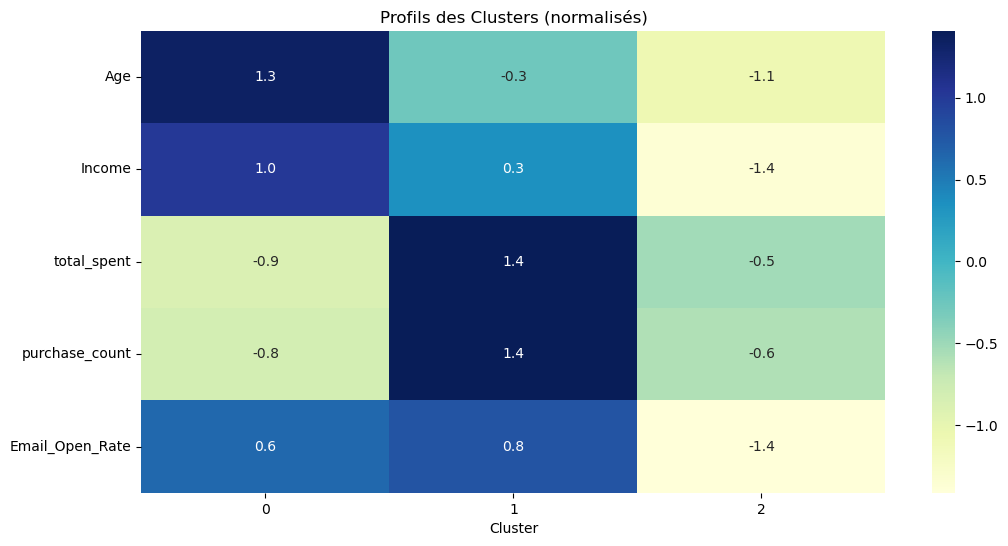

In [ ]:
# Préparation des données pour la visualisation
cluster_profiles = df.groupby('Cluster')[['Age', 'Income', 'total_spent', 'purchase_count', 'Email_Open_Rate']].mean()

# Normalisation pour une meilleure visualisation
cluster_profiles_scaled = pd.DataFrame(
    scaler.fit_transform(cluster_profiles),
    columns=cluster_profiles.columns,
    index=cluster_profiles.index
)

# Heatmap des caractéristiques des clusters
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_profiles_scaled.T, cmap='YlGnBu', annot=True, fmt=".1f")
plt.title('Profils des Clusters (normalisés)')
plt.savefig("clusters_profils.png")
plt.show()